# Instructions

Find a dataset on Data.gov, Ed.Gov, Kaggle, or other sources that is interesting to you and is suitable for regression analysis or a classification model.
1. Problem statement. Describe the dataset, analyze the target variable, and state your prediction goal.  5 points

2. Basic data cleaning.  Drop unwanted features.  Address missing values.  Remove Duplicates. Check if there are any inconsistent inputs for categorical variables. Transform categorical variables into numeric. Use boxplots or histogram to identify outliers for numeric variables and remove them. 20 points

3. Feature Engineering. 20 points
Feature selection. Use graphs, ANOVA test, Chi-squared test to reduce the dimension. Any variables with zero to little variance?  Any features Irrelevant to the target variable? Any high-correlated Features?  
Feature scaling. Does this algorithm require normalized data or standardized data?
Are there any categorical variables need to be changed to dummy variables?
4. Build the prediction model. 20 points
Does this data need to be balanced?
Do you use train_test_split or cross validation to validate the result?
Which algorithm is appropriate for this problem?
Which metrics do you use to evaluate the prediction model?
If the accuracy score or r-squared score is low, generally it is considered as a bad model. Explain why your model failed.
5. Save the report and upload it to your Github repository. Upload the .ipyn file to MOODLE.
Please print out the result at each step and verify it. Do not print out the results of multiple steps all at once. The readability of your report can greatly affect your score. 5 points
6. Record a screen captured video to explain each step in your report. In your video, you are expected walk through the report and explain to your audience the purpose of each step, the method you use, as well as the result. For example, when using ANOVA f-test, you shall explain that this test is used to find variables that have little variance between the classes for the target; these variables are irrelevant to the target variable and shall be removed. You shall also explain how you interpret the f-scores and p-values and the result - which variables shall be removed.  
You are also expected to explain the logic for the algorithm you use, which we have covered during the lessons.  
If you have not used any screen recorder, I suggest  the trial version of Camtasia Screen Recorder, LOOM, or Screencastify. They all allow you to record videos for free with the trial version, though some only allows you to share with a link and does not allow you to download the recording. Posting the link to the video in the Assignment folder would be fine. 30 points



## **Source of Dataset**

https://www.kaggle.com/datasets/amrmaree/student-performance-prediction

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1] Problem statement.
Describe the dataset, analyze the target variable, and state your prediction goal.  
*5 points*

This dataset contains information about hundreds of students- their academic performance, study habits, and external factors that affect their final exam scores and if they pass or fail a course.
* **Target variable:** 'Pass_Fail' (Pass) or (Fail)
* **Prediction goal:** To predict a whether a student is going to pass or fail a course based on their study habits, attendance, and other background factors.

In [2]:
#loading the data
df = pd.read_csv('student_performance_dataset.csv')
print(df)

    Student_ID  Gender  Study_Hours_per_Week  Attendance_Rate  \
0         S147    Male                    31        68.267841   
1         S136    Male                    16        78.222927   
2         S209  Female                    21        87.525096   
3         S458  Female                    27        92.076483   
4         S078  Female                    37        98.655517   
..         ...     ...                   ...              ...   
703       S492    Male                    14        84.658761   
704       S301    Male                    35        60.278990   
705       S473    Male                    25        98.384969   
706       S307  Female                    21        96.148012   
707       S046  Female                    22        80.404392   

     Past_Exam_Scores Parental_Education_Level Internet_Access_at_Home  \
0                  86              High School                     Yes   
1                  73                      PhD                      No 

In [3]:
print (df.dtypes)

Student_ID                     object
Gender                         object
Study_Hours_per_Week            int64
Attendance_Rate               float64
Past_Exam_Scores                int64
Parental_Education_Level       object
Internet_Access_at_Home        object
Extracurricular_Activities     object
Final_Exam_Score                int64
Pass_Fail                      object
dtype: object


# 2] Basic data cleaning.  
Drop unwanted features.  Address missing values.  Remove Duplicates. Check if there are any inconsistent inputs for categorical variables. Transform categorical variables into numeric. Use boxplots or histogram to identify outliers for numeric variables and remove them.

*20 points*

In [4]:
#drop unwanted features
df_update= df.drop(columns=['Student_ID', 'Final_Exam_Score']) #final exam score variable implicitly tells the target variable so remove to not cheat the model
print(df_update)
#will reconsider dropping other features after testing correlation to target variable

     Gender  Study_Hours_per_Week  Attendance_Rate  Past_Exam_Scores  \
0      Male                    31        68.267841                86   
1      Male                    16        78.222927                73   
2    Female                    21        87.525096                74   
3    Female                    27        92.076483                99   
4    Female                    37        98.655517                63   
..      ...                   ...              ...               ...   
703    Male                    14        84.658761                78   
704    Male                    35        60.278990                83   
705    Male                    25        98.384969                75   
706  Female                    21        96.148012                84   
707  Female                    22        80.404392                93   

    Parental_Education_Level Internet_Access_at_Home  \
0                High School                     Yes   
1                      

In [5]:
#any missing values?
print(df_update.isnull().sum())

Gender                        0
Study_Hours_per_Week          0
Attendance_Rate               0
Past_Exam_Scores              0
Parental_Education_Level      0
Internet_Access_at_Home       0
Extracurricular_Activities    0
Pass_Fail                     0
dtype: int64


In [6]:
#remove any duplicates
df_nodupes = df_update.drop_duplicates()
print(df_nodupes.shape)

(500, 8)


In [7]:
#check for inconsistent inputs for categorical variables: Gender, Parental Education Level, Internet Access at Home, Extracurricular Activities, Pass/ Fail
categorical_cols = df_nodupes.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"Unique values for {col}:")
    print(df_nodupes[col].unique())


Unique values for Gender:
['Male' 'Female']
Unique values for Parental_Education_Level:
['High School' 'PhD' 'Bachelors' 'Masters']
Unique values for Internet_Access_at_Home:
['Yes' 'No']
Unique values for Extracurricular_Activities:
['Yes' 'No']
Unique values for Pass_Fail:
['Pass' 'Fail']


In [8]:
#transform categorical variable 'Pass_Fail' to numerical
df_numeric = df_nodupes.copy()
df_numeric['Pass_Fail'] = df_numeric['Pass_Fail'].replace({'Pass': 1, 'Fail': 0})
print(df_numeric['Pass_Fail'].value_counts())

Pass_Fail
0    354
1    146
Name: count, dtype: int64


/tmp/ipython-input-841623179.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numeric['Pass_Fail'] = df_numeric['Pass_Fail'].replace({'Pass': 1, 'Fail': 0})


*Note that the target variable is imbalanced*

In [9]:
#transform other categorical variables to numerical
df_numeric['Gender'].replace(['Female', 'Male'],[0, 1], inplace = True)
df_numeric['Parental_Education_Level'].replace(['High School', 'PhD', 'Bachelors', 'Masters'],[0, 1, 2, 3], inplace = True)
df_numeric['Internet_Access_at_Home'].replace(['Yes', 'No'],[1, 0], inplace = True)
df_numeric['Extracurricular_Activities'].replace(['Yes', 'No'],[1, 0], inplace = True)
#keeping in mind this code and the one above is suggested to be updated for future updates


/tmp/ipython-input-2527007940.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['Gender'].replace(['Female', 'Male'],[0, 1], inplace = True)
/tmp/ipython-input-2527007940.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numeric['Gender'].replace(['Female', 'Male'],[0, 1], inplace 

In [10]:
#confirming data types have changed
print (df_numeric.dtypes)

Gender                          int64
Study_Hours_per_Week            int64
Attendance_Rate               float64
Past_Exam_Scores                int64
Parental_Education_Level        int64
Internet_Access_at_Home         int64
Extracurricular_Activities      int64
Pass_Fail                       int64
dtype: object


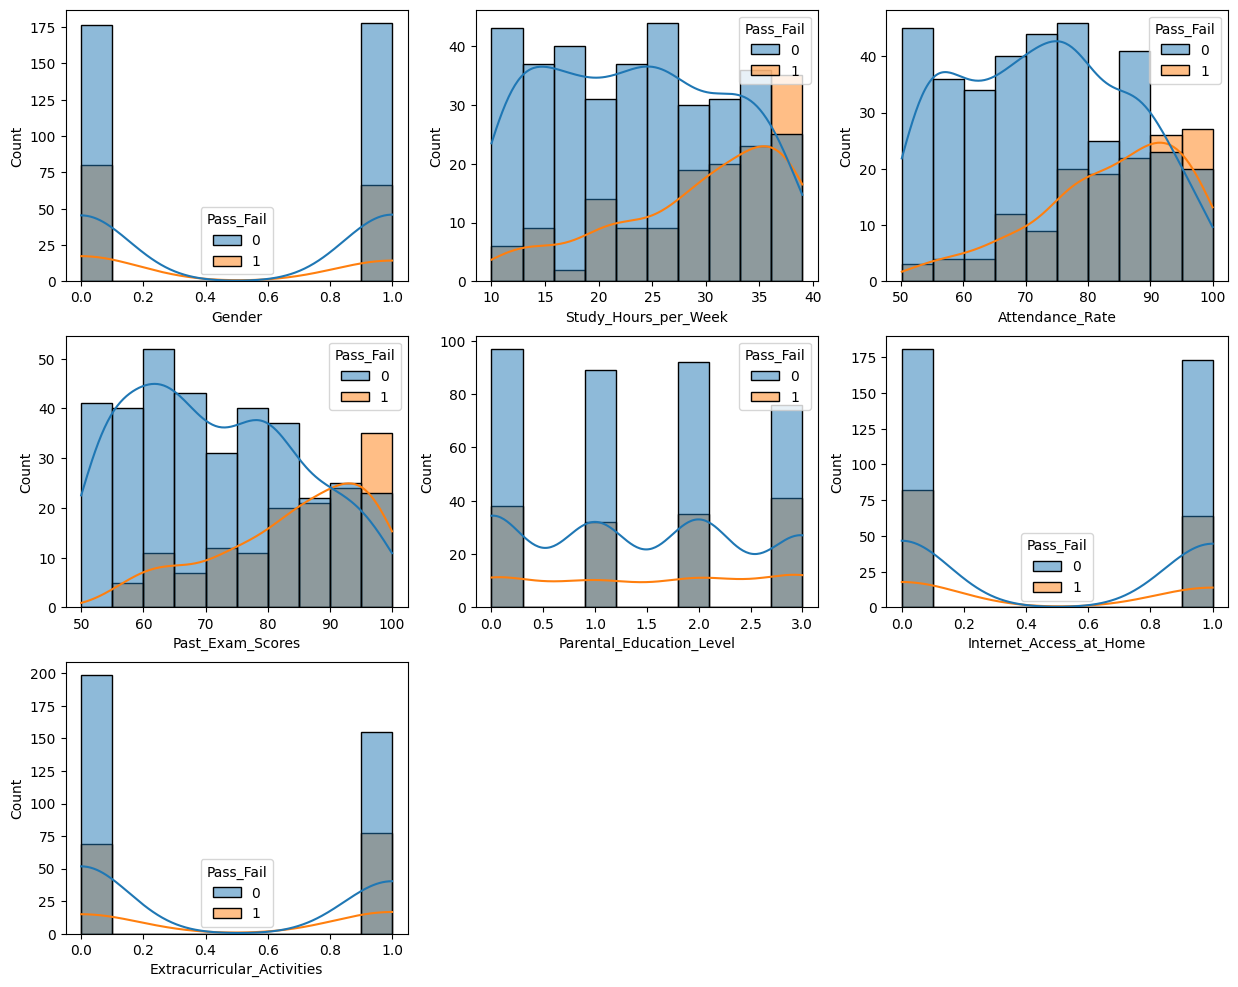

In [14]:
#histogram for outliers/ comparisons
fig=plt.figure(figsize=(15, 12))
ax=fig.add_subplot
for i in range(len(num_list)):
    column=num_list[i]
    sub=fig.add_subplot(3,3,i+1)
    sns.histplot(x=column, data=df_numeric, hue='Pass_Fail', kde=True)

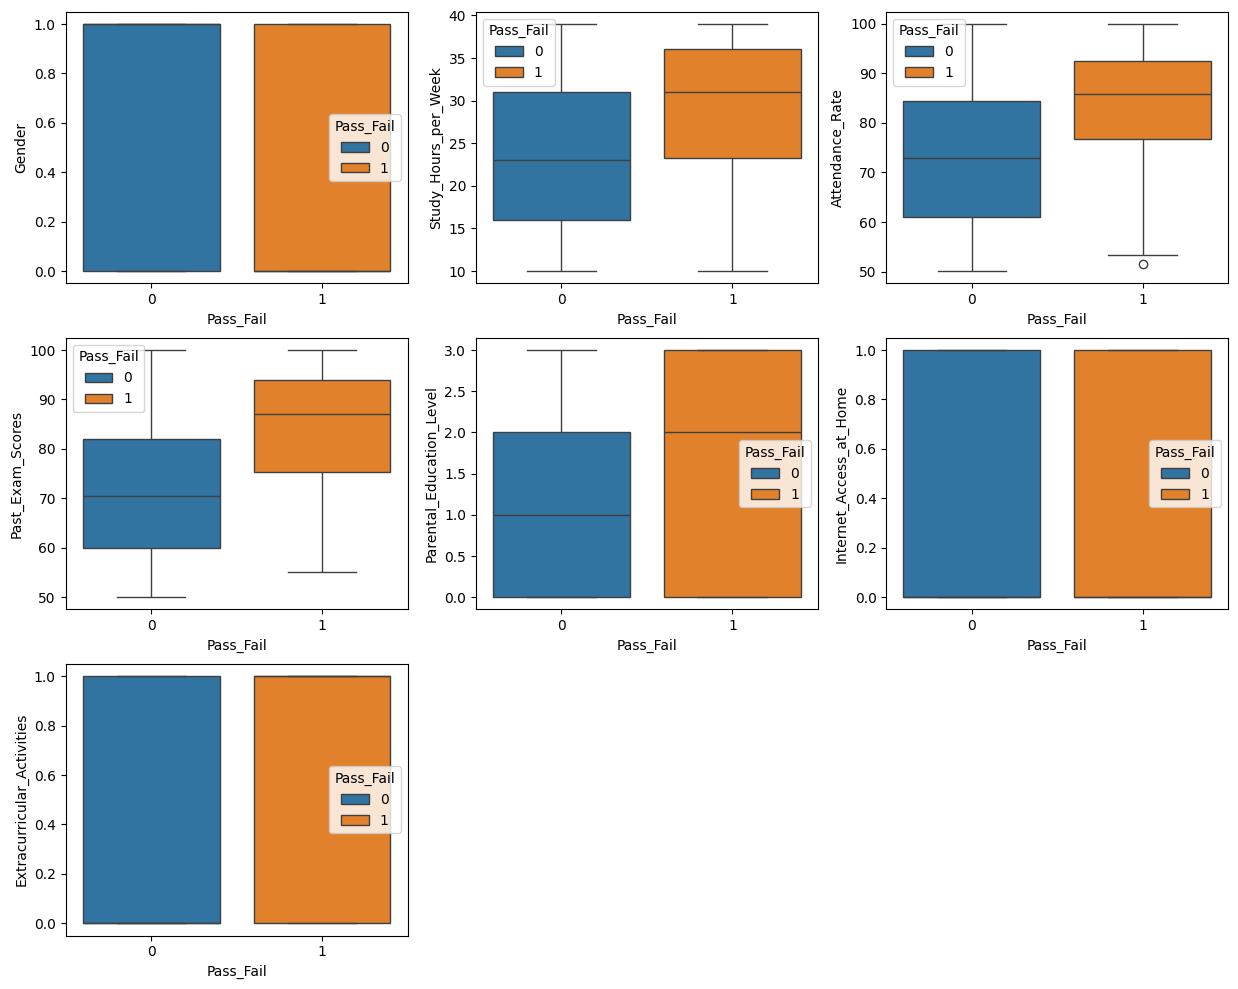

In [13]:
#boxplots for outliers/ comparisons
num_list=['Gender', 'Study_Hours_per_Week', 'Attendance_Rate', 'Past_Exam_Scores', 'Parental_Education_Level', 'Internet_Access_at_Home', 'Extracurricular_Activities']
fig=plt.figure(figsize=(15, 12))

for i in range(len(num_list)):
    column=num_list[i]
    sub=fig.add_subplot(3,3,i+1)
    sns.boxplot(x='Pass_Fail', y=column, data=df_numeric, hue='Pass_Fail')

not dropping any features- both histograms and boxplots don't show significant outliers to warrant dropping a variable. Also noting that the binary variables (gender, internet access, and extracurricular activities) are just showing counts

# 3] Feature Engineering.
*20 points *

Feature selection.
* Use graphs, ANOVA test, Chi-squared test to reduce the dimension. Any variables with zero to little variance? Any features Irrelevant to the target variable? Any high-correlated Features?

Feature scaling.
* Does this algorithm require normalized data or standardized data? Are there any categorical variables need to be changed to dummy variables?

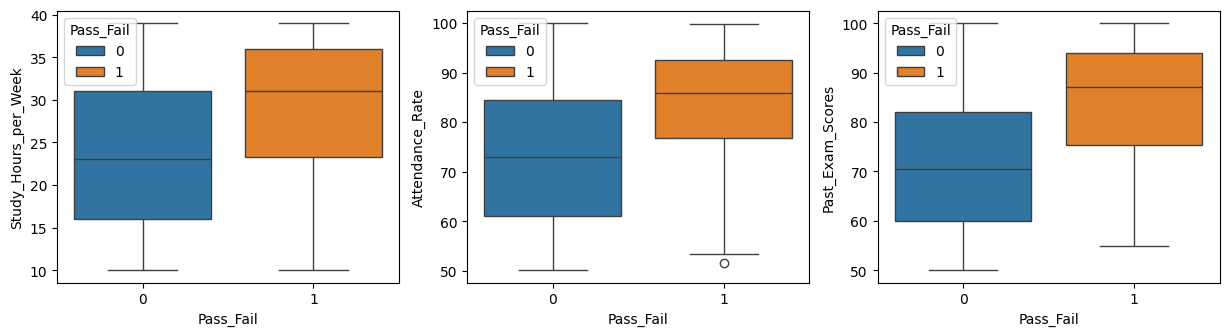

In [15]:
#grouped boxplots for numerical features vs. target
num_list=['Study_Hours_per_Week', 'Attendance_Rate', 'Past_Exam_Scores']
fig=plt.figure(figsize=(15, 12))
for i in range(len(num_list)):
    column=num_list[i]
    sub=fig.add_subplot(3,3,i+1)
    chart= sns.boxplot(x='Pass_Fail', y=column, data=df_numeric, hue='Pass_Fail')

In [16]:
#anova f-test to obtain f-scores
from sklearn.feature_selection import SelectKBest, f_classif, chi2
x = df_numeric.loc[:, ['Study_Hours_per_Week', 'Attendance_Rate', 'Past_Exam_Scores']]
y = df_numeric.loc[:, 'Pass_Fail']

fs = SelectKBest(score_func=f_classif, k='all')
features = fs.fit(x, y)
np.set_printoptions(suppress= True)
print(features.scores_)
print(features.pvalues_)

[48.58028351 72.19125932 90.31023474]
[0. 0. 0.]


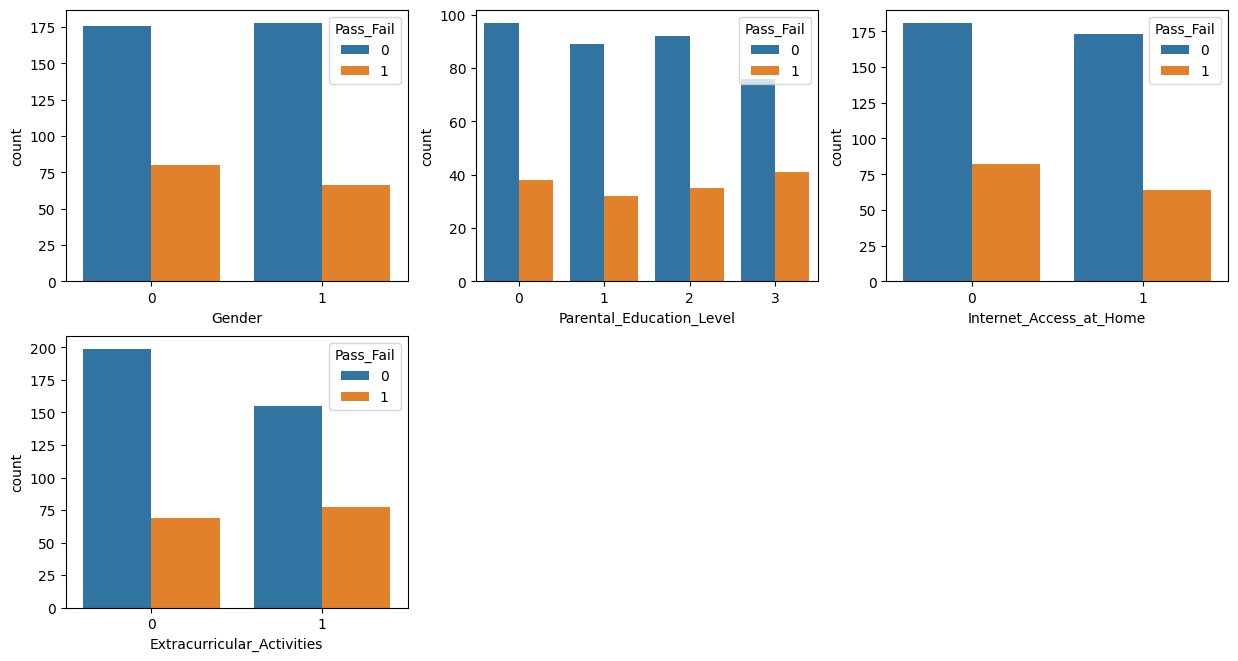

In [17]:
#grouped bar chart for categorical features vs. target
num_list=['Gender', 'Parental_Education_Level', 'Internet_Access_at_Home', 'Extracurricular_Activities']
fig=plt.figure(figsize=(15, 12))
for i in range(len(num_list)):
    column=num_list[i]
    sub=fig.add_subplot(3,3,i+1)
    chart= sns.countplot(x=column, hue='Pass_Fail', data=df_numeric)

In [18]:
#chi-squared test
x = df_numeric.loc[:, ['Gender', 'Parental_Education_Level', 'Internet_Access_at_Home', 'Extracurricular_Activities']]
y = df_numeric.loc[:, 'Pass_Fail']

chi = SelectKBest(score_func=chi2, k='all')
Features = chi.fit(x, y)
print(Features.scores_) #higher the better
print(Features.pvalues_)

[0.54598626 1.12737481 0.55272629 1.78625146]
[0.45996236 0.28833599 0.45720587 0.18138355]


In [19]:
#correlation analysis
corr = df_numeric.corr()
print(corr)

                              Gender  Study_Hours_per_Week  Attendance_Rate  \
Gender                      1.000000             -0.082291         0.010712   
Study_Hours_per_Week       -0.082291              1.000000        -0.039701   
Attendance_Rate             0.010712             -0.039701         1.000000   
Past_Exam_Scores            0.036829             -0.013381        -0.022741   
Parental_Education_Level   -0.072441              0.069686         0.032376   
Internet_Access_at_Home     0.002757              0.051182         0.030660   
Extracurricular_Activities  0.014313             -0.046821         0.007578   
Pass_Fail                  -0.046182              0.298128         0.355821   

                            Past_Exam_Scores  Parental_Education_Level  \
Gender                              0.036829                 -0.072441   
Study_Hours_per_Week               -0.013381                  0.069686   
Attendance_Rate                    -0.022741                  0.03

In [20]:
#top 5 most correlated features with 'Pass_Fail'
corr_pass_fail = corr['Pass_Fail'].sort_values(ascending=False)
print(corr_pass_fail.head(6))

Pass_Fail                     1.000000
Past_Exam_Scores              0.391801
Attendance_Rate               0.355821
Study_Hours_per_Week          0.298128
Extracurricular_Activities    0.081640
Parental_Education_Level      0.051061
Name: Pass_Fail, dtype: float64


In [21]:
#irrelevant features appear to be Gender, Parent Education Level and Internet Access at Home- drop them
#Extracurricular variable shows less correlation but pvalue is a little close
df_updated = df_numeric.drop(columns=['Gender', 'Parental_Education_Level', 'Internet_Access_at_Home'])
print(df_updated)

     Study_Hours_per_Week  Attendance_Rate  Past_Exam_Scores  \
0                      31        68.267841                86   
1                      16        78.222927                73   
2                      21        87.525096                74   
3                      27        92.076483                99   
4                      37        98.655517                63   
..                    ...              ...               ...   
701                    21        69.858192                90   
702                    22        93.349688                76   
703                    14        84.658761                78   
705                    25        98.384969                75   
707                    22        80.404392                93   

     Extracurricular_Activities  Pass_Fail  
0                             1          1  
1                             0          0  
2                             0          0  
3                             0          1  
4     

No dummy variables needed since the remaining categorical variable is binary

# 4] Build the prediction model.
*20 points*

Does this data need to be balanced? Do you use train_test_split or cross validation to validate the result? Which algorithm is appropriate for this problem? Which metrics do you use to evaluate the prediction model? If the accuracy score or r-squared score is low, generally it is considered as a bad model. Explain why your model failed.

In [22]:
#recalling from earlier that data needs to be balanced
print(df_updated['Pass_Fail'].value_counts())

Pass_Fail
0    354
1    146
Name: count, dtype: int64


In [29]:
#splitting the data into training and testing sets by oversampling
X = df_updated.drop('Pass_Fail', axis=1)
y = df_updated['Pass_Fail']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#balancing the data
os = SMOTE(random_state=0)
oversampled_x, oversampled_y = os.fit_resample(x_train, y_train)

print(x_train.shape)
print(oversampled_x.shape)

print(oversampled_y.value_counts())

(400, 4)
(566, 4)
Pass_Fail
0    283
1    283
Name: count, dtype: int64


In [24]:
#Logistic Regression model
model = LogisticRegression(max_iter=2000)
model.fit(oversampled_x, oversampled_y.values.ravel())

LogisticRegression(max_iter=2000)

Logistic regression is beneficial for this dataset and target because it predicts the probability of such binary outcomes.

In [25]:
# Accuracy score
test_pred = model.predict(x_test)
print("Accuracy Score:", accuracy_score(y_test, test_pred))

Accuracy Score: 0.83


In [27]:
#cross validation
scores = cross_val_score(model, oversampled_x, oversampled_y.values.ravel(), cv=10) # Using 10-fold cross-validation
print(scores)
print(scores.mean())

[0.77192982 0.78947368 0.84210526 0.77192982 0.78947368 0.85964912
 0.85714286 0.82142857 0.82142857 0.78571429]
0.8110275689223057


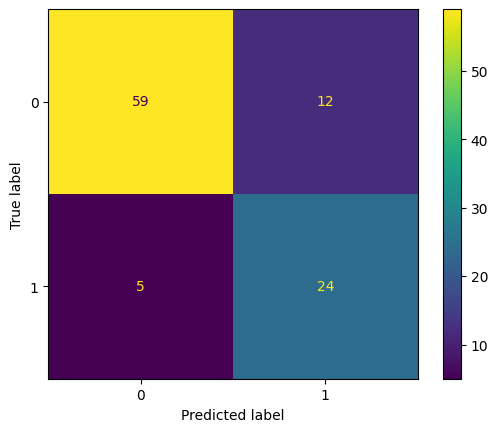

In [28]:
#confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)

# 5] Save the report and upload it to your Github repository. Upload the .ipyn file to MOODLE.
Please print out the result at each step and verify it. Do not print out the results of multiple steps all at once. The readability of your report can greatly affect your score.

*5 points*